<a href="https://colab.research.google.com/github/hagabbar/craft_prospect/blob/master/LSTM_classification_approach.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# Import required scripts to run
import numpy as np
from keras import Sequential
from keras.layers import LSTM, Dense, Embedding, SpatialDropout1D
import matplotlib.pyplot as plt


In [0]:
"""
This is a script which will check for non-random subsequences 
from the quantum random number generator onboard the CubeSat. 
The code will first perform a benchmark suite of tests known 
as Diehard tests. We will then use the results from these 
tests in order to train and compare the results of a 
neural network approach (LSTMs).
"""

# Define important global variables here
tot_num_samples = 100000 # total number of training samples (50/50 split between rand and non-rand)
train_split = int(int(tot_num_samples/2) * 0.9) # use 90% for training, 10% for testing
bitstream_len = 64     # length of observation window of network
batch_size = 128         # batch size (how many samples NN sees during each iteration)
bit_max_number = 4294967295
snr = 6.0              # signal to noise ratio of injected signal
np.random.seed(42)
#true_rand_url = "https://raw.githubusercontent.com/hagabbar/craft_prospect/master/key_assurance/true_random_nums.txt"

# Generate a set of pseudo random numbers
pseudo_rand_data_train = np.random.randint(low=0,high=bit_max_number,size=(train_split,bitstream_len),dtype=np.uint32)
pseudo_rand_data_test = np.random.randint(low=0,high=bit_max_number,size=(int(tot_num_samples/2) - train_split,bitstream_len),dtype=np.uint32)
pseudo_rand_labels_train = np.ones(train_split)
pseudo_rand_labels_test = np.ones(int(tot_num_samples/2) - train_split)

# Inject noise signal into pseudo random number sequences (sine-wave in binary)
time = np.arange(0,bitstream_len,1)
nonrand_seq = (np.sin(time) + 1)
noise_data_train = (nonrand_seq / np.max(nonrand_seq)) + np.random.uniform(low=0,high=(0.0),size=(train_split,bitstream_len))
noise_data_train = np.float32(noise_data_train) / np.float32(np.max(noise_data_train))
noise_data_train *= bit_max_number
noise_data_train = np.uint32(noise_data_train)

noise_data_test = (nonrand_seq / np.max(nonrand_seq)) + np.random.uniform(low=0,high=(0.0),size=(int(tot_num_samples/2) - train_split,bitstream_len))
noise_data_test = np.float32(noise_data_test) / np.float32(np.max(noise_data_test))
noise_data_test *= bit_max_number
noise_data_test = np.uint32(noise_data_test)

noise_labels_train = np.zeros(train_split)
noise_labels_test = np.zeros(int(tot_num_samples/2) - train_split)

# Load in set of true random numbers
#true_rand_data_train = np.loadtxt(true_rand_url)[:train_split,:]
#true_rand_data_test = np.loadtxt(true_rand_url)[train_split:int(tot_num_samples/2),:]
#true_rand_labels_train = np.zeros(train_split)
#true_rand_labels_test = np.zeros(int(tot_num_samples/2) - train_split)

# Combine all data and labels into two arrays (x and y respectively)
X_train = np.concatenate((pseudo_rand_data_train,noise_data_train))
X_test = np.concatenate((pseudo_rand_data_test,noise_data_test))
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1],1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1],1)

Y_train = np.concatenate((pseudo_rand_labels_train,noise_labels_train))
Y_test = np.concatenate((pseudo_rand_labels_test,noise_labels_test))

# Randomly shuffle training sets
idx_shuffle = np.random.permutation(int(train_split*2))
X_train = X_train[idx_shuffle,:]
Y_train = Y_train[idx_shuffle]


0.0


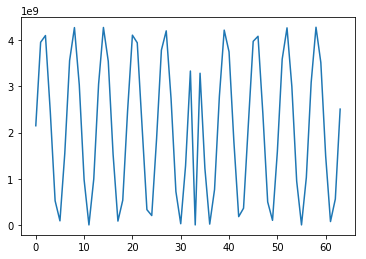

In [112]:
cnt = 0
plt.plot(noise_data_train[1])
print(Y_train[cnt])

In [0]:
print(time.shape)

(64,)


In [0]:
# Set-up LSTM network
lstm_out = 200
batch_size = 32

model = Sequential()
model.add(LSTM(lstm_out, activation='relu',input_shape=(bitstream_len,1),return_sequences=True))
model.add(LSTM(lstm_out, activation='relu'))
model.add(Dense(1,activation='sigmoid'))
model.compile(loss = 'binary_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model.summary())

In [116]:
# Train LSTM network
model.fit(X_train, Y_train, batch_size = batch_size, epochs = 5,  verbose = 1)

Epoch 1/5
 7104/90000 [=>............................] - ETA: 11:19 - loss: 13.5960 - acc: 0.1509

KeyboardInterrupt: ignored

In [12]:
score,acc = model.evaluate(X_test,Y_test,batch_size=batch_size,verbose=2)
print("Score: %.2f" % (score))
print("Validation Accuracy: %.2f" % (acc))

Score: 7.93
Validation Accuracy: 0.51
